In [1]:
# Cell 1: Import Required Libraries
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Set the seed for reproducibility
SEED = 42
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


In [2]:
# Cell 2: Define Constants and Directories
BATCH_SIZE = 32
INPUT_SIZE = (256, 256)
MEAN = (0.6181, 0.4643, 0.4194)
STD = (0.1927, 0.1677, 0.1617)

main_data_dir = r"C:\Users\Josh\Desktop\CUDA\skindiseases"
val_dir = os.path.join(main_data_dir, "val")
test_dir = os.path.join(main_data_dir, "test")

# Load class names
val_dataset = datasets.ImageFolder(root=val_dir)
class_names = list(val_dataset.classes)
print("Class to label mapping:", val_dataset.class_to_idx)


Class to label mapping: {'Acne': 0, 'Eczema': 1, 'Normal': 2, 'Perioral Dermatitis': 3, 'Psoriasis': 4, 'Rosacea': 5, 'Seborrheic Dermatitis': 6, 'Tinea Faciei': 7}


In [3]:
# Cell 3: Define Image Transformations
transform_val_test = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Load the datasets with the transformations
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val_test)

# Create DataLoaders for validation and test datasets
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [4]:
# Cell 4: Define the Model Structure
import torch.nn as nn
import torchvision.models as models

class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=8):
        super(ModifiedAlexNet, self).__init__()
        self.model = models.alexnet(pretrained=True)  # Set pretrained=False since we are loading custom weights
        self.model.classifier[6] = nn.Linear(4096, num_classes)  # Modify the final layer for 8 classes

    def forward(self, x):
        return self.model(x)

# Instantiate and load the model
num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedAlexNet(num_classes=num_classes).to(device)

# Load the trained weights
model_path = r"C:\Users\Josh\Desktop\CUDA\alexnetmodel\45.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set to evaluation mode
print(f"Loaded model from {model_path}")


c:\Users\Josh\Desktop\CUDA\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Josh\Desktop\CUDA\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from C:\Users\Josh\Desktop\CUDA\alexnetmodel\45.pth


C:\Users\Josh\AppData\Local\Temp\ipykernel_14608\4209384187.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

In [5]:
# Cell 5: Evaluation Function
def evaluate_model(model, data_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix on Alexnet Without XGBOOST')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


Classification Report:

                       precision    recall  f1-score   support

                 Acne       0.46      0.54      0.50        50
               Eczema       0.45      0.28      0.35        50
               Normal       0.78      0.58      0.67        50
  Perioral Dermatitis       0.48      0.68      0.56        50
            Psoriasis       0.46      0.38      0.42        50
              Rosacea       0.52      0.58      0.55        50
Seborrheic Dermatitis       0.36      0.42      0.39        50
         Tinea Faciei       0.40      0.38      0.39        50

             accuracy                           0.48       400
            macro avg       0.49      0.48      0.48       400
         weighted avg       0.49      0.48      0.48       400



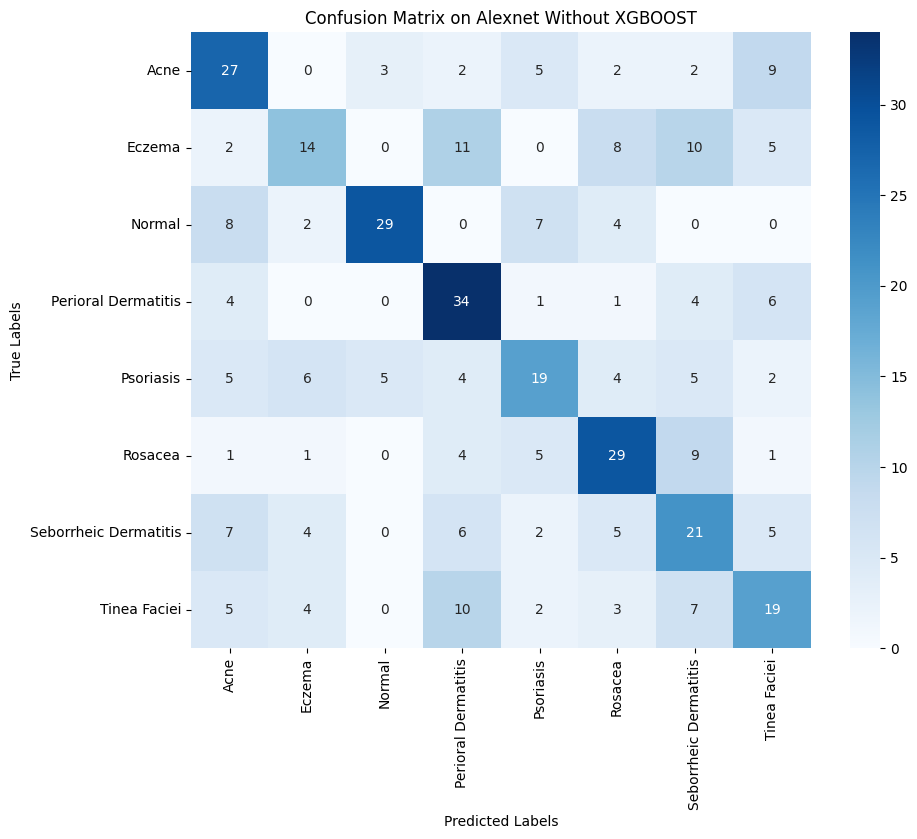

In [8]:

evaluate_model(model, test_loader, device, class_names)
